In [2]:
import pyodbc
from meyerDB import cable_connection

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.utils import shuffle
from scipy.optimize import curve_fit
from copy import deepcopy

from keras import models
from keras.layers import Dense, Dropout


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

def logifunc(x,x0,k,l):
    #l = 2300
    return l / (1 + np.exp(-k*(x - x0)))

Database connection ok


C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and 

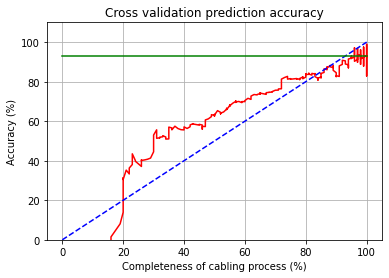

In [31]:
# Dynamic whole ship cable quantities
# Predictors:
# Current quantity, drawings
# Algorithms:
# average drawing cables


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, count(*) FROM area_dataset as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

# init lpo split
p = 1 #ships
lpo = LeavePOut(p)


model = linear_model.LinearRegression()


accs = []
dum_accs = []
best_accs = []
completeness = []
for train_i, test_i in lpo.split(y):
    # train regression model
    model.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # collect time series train data
    start = -100
    step = 1
    x = []
    # train and evaluate
    for i in test_i:
        ship = ships[i]
        for wk in range(start, 1, step):
            # train the model
            linear_pred = model.predict(gt[[i]].reshape(1, 1))[0]

            cursor.execute('''
                DECLARE @tot_cables float;
                DECLARE @tot_pred_cables int;
                SET @tot_pred_cables = {};
                SET @tot_cables = (SELECT count(*) FROM area_dataset WHERE pw <= {} AND project_id={} );

                SELECT t1.project_id, t1.area, current_cables, 
                (current_cables/@tot_cables)*@tot_pred_cables as pred, total_cables
                FROM (
                SELECT project_id, area, count(*) as current_cables FROM area_dataset WHERE pw <= {} AND project_id={} 
                GROUP BY project_id, area) t1 
                LEFT JOIN 
                (SELECT project_id, area, count(*) as total_cables FROM area_dataset WHERE project_id={} 
                GROUP BY project_id, area) t2 ON t1.project_id=t2.project_id AND t1.area=t2.area 
            '''.format(linear_pred, wk, ship, wk, ship, ship)
            )
            data = np.array(cursor.fetchall())
            if data.shape[0] == 0: continue
            preds = data[:, -2]
            y_true = data[:, -1]
            _mape = mape(y_true, preds)
            accs.append(1-_mape)

            dum_accs.append(1-0)
            cursor.execute('''
                SELECT 
                (SELECT count(*) FROM area_dataset WHERE project_id={} AND pw <={})/
                cast((SELECT count(*) FROM area_dataset WHERE project_id={}) as float)
                
            '''.format(ship, wk, ship)
            )
            readiness = cursor.fetchone()[0]
            completeness.append(int(round(100*readiness, 0)))
            '''
            estimated_completeness = np.square(sequence.sum()/linear_pred)
            if estimated_completeness > 1.0: estimated_completeness = 1.0
            w1, w2 = 1-estimated_completeness, estimated_completeness
            avpred = (w1*linear_pred + w2*pred)/(w1+w2)
            dum_mape = abs(avpred-y[i])/y[i]
            best_accs.append(1-dum_mape)
            '''
            best_accs.append(1-0)

org_completeness = completeness
accs = np.array(accs)
completeness = np.array(completeness)
p = np.argsort(completeness)
completeness = completeness[p]
accs = accs[p]


n = 10

best_accs = np.array(best_accs)[p]
#accs = deepcopy(best_accs)
for i in np.arange(0, 101, 1):
    best_accs[np.where(completeness == i)] = best_accs[np.where(completeness == i)].mean()
    #accs[np.where(completeness == i)] = accs[np.where(completeness == i)].mean()



best_accs = moving_average(best_accs, n)
accs = moving_average(accs, n)


plt.plot(completeness[n-1:], 100*accs, 'r')
plt.plot(completeness, completeness, 'b--')
#plt.plot(completeness[n-1:], 100*best_accs, 'k')

plt.plot([0, 100], [93, 93], 'g')
#¬plt.legend(['min', 'Ensemble model; Linear regression (GT) + Batch prediction', 'Linear regression (GT)'])

plt.title("Cross validation prediction accuracy")
plt.xlabel("Completeness of cabling process (%)")
plt.ylabel('Accuracy (%)')
#plt.legend(['Cable batch prediction', 'Linear regression (GT)'])

plt.ylim(0, 110)
plt.grid(which='major')

plt.show()
